In [2]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(utils)
importlib.reload(my_utils)
from glob import glob
import matplotlib.pyplot as plt
import sys
#del sys.modules['dataset']
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 1924, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 1924 (delta 40), reused 33 (delta 17), pack-reused 1860
Receiving objects: 100% (1924/1924), 26.25 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (643/643), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#-------------------------------
agn_file = '/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv'
agn_df = pd.read_csv(agn_file)
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)

AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part
AGN_1H2106 = AGN_1H2106.handle_dups().prune_outliers().resample_dataset(num_samples=1).normalize(normalize_y_by='individual') \
  .set_union_x().zero_fill().make_masks(frac=0.5)

print(
    AGN_1H2106.union_x.shape,
    AGN_1H2106.dataset.shape,
    AGN_1H2106.subsampled_mask.shape,
    AGN_1H2106.recon_mask.shape
  )


indexes of outliers to be pruned, if any: [600 601]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [418 583]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [ 98 205 260 261 554 555]
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 5
new dataset length: 10
created union_x attribute of length 1445
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (10, 619, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(1445,) (10, 619, 3) (10, 619) (10, 619)


In [ ]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Catalina data
#--------------------------------------------------------------------------------------------------------


lc_files = glob('/content/hetvae/data/CAT/*/*')[:50]

Catalina = DataSet().add_files(lc_files).files_to_numpy().handle_dups().prune_outliers().resample_dataset(num_samples=1).normalize(normalize_y_by='individual') \
        .set_union_x().zero_fill().make_masks(frac=0.5)

print(
    Catalina.files, '\n',
    Catalina.union_x.shape,
    Catalina.dataset.shape,
    Catalina.subsampled_mask.shape,
    Catalina.recon_mask.shape
  )


dims of /content/hetvae/data/CAT/MLS/MLS160904:221110-060547_19.78.dat:	(72, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170222:122411+113751_20.91.dat:	(87, 3)
dims of /content/hetvae/data/CAT/MLS/MLS180319:105723+035711_20.73.dat:	(142, 3)
dims of /content/hetvae/data/CAT/MLS/MLS171024:001549+031138_20.85.dat:	(152, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170105:074944+212124_20.56.dat:	(426, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170521:115341+363537_20.76.dat:	(99, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170310:130357+363042_17.37.dat:	(497, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170107:121527-012403_20.34.dat:	(402, 3)
dims of /content/hetvae/data/CAT/MLS/MLS180516:211854-035803_21.02.dat:	(43, 3)
dims of /content/hetvae/data/CAT/MLS/MLS161019:012917-043310_19.39.dat:	(203, 3)
dims of /content/hetvae/data/CAT/MLS/MLS170323:105609+434657_19.66.dat:	(420, 3)
dims of /content/hetvae/data/CAT/MLS/MLS171023:002448+095950_20.3.dat:	(93, 3)
dims of /content/hetvae/data/CAT/M

dims of /content/hetvae/data/EDELSON/NGC4593_W1.dat:	(150, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [83 96]
indexes of outliers to be pruned, if any: [ 87  96 102]
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 8
created union_x attribute of length 1878
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (8, 265, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
['/content/hetvae/data/EDELSON/NGC4593_W1.dat', '/content/hetvae/data/EDELSON/NGC5548_W1.dat', '/content/hetvae/data/EDELSON/NGC5548_HX.dat', '/content/hetvae/data/EDELSON/NGC5548_SX.d

/content/hetvae/src/dataset.py:154: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


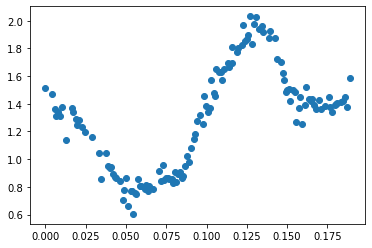

In [3]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]

# hypers: 
Edelson = DataSet().add_files(lc_files).files_to_numpy().handle_dups().prune_outliers().resample_dataset(num_samples=1).normalize().reorder() \
        .set_union_x().zero_fill().error_to_sample_weight().make_masks(frac=0.5)

print(
    Edelson.files, '\n',
    Edelson.union_x.shape,
    Edelson.dataset.shape,
    Edelson.subsampled_mask.shape,
    Edelson.recon_mask.shape
  )

plt.scatter(Edelson.dataset[5,:-130,0], Edelson.dataset[5,:-130,1])

In [4]:
# num heads?
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat', mse_weight=5.0, n=256, net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=16, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)



In [6]:
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
LightCurves = np.concatenate((Edelson.dataset, Edelson.subsampled_mask[:,:,np.newaxis], Edelson.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
print(LightCurves.shape)


(8, 265, 5)


In [8]:
training, valid = np.split(LightCurves, [int(np.floor(1*len(LightCurves)))])# shuffle?
train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
       

In [9]:
net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x)) # , device="cuda"
params = list(net.parameters())
optimizer = optim.Adam(params, lr=.00001)

In [10]:
def train(net, optimizer,epoch, train_loader, args, device="cuda"):
      
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          #train_batch[:,:,2] = torch.ones((train_batch[:,:,3].shape))
          train_batch = train_batch.to(device)
          x = train_batch[:,:,0]
          y = train_batch[:,:,1:2]
          
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]
          sample_weight = train_batch[:,:,2:3]
          # weights for loss in analogy to standard weighted least squares error 
  
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              y * subsampled_mask, subsampled_mask
          ), -1) 
          recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                  y * recon_mask, recon_mask
              ), -1)
          


    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              x, # context_x, times
              context_y,             # context_y
              x, # target_x, same times? 
              recon_context_y,
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              #sample_weight = 1.sample_weight,

          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      

In [ ]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001

In [11]:
for epoch in range(1, 101):#args.niters + 1):
    train(net, optimizer, epoch, train_loader, args)

Iter: 100, train loss: 6.1211, avg nll: 1.3410, avg kl: 0.3790, mse: 0.880224, mae: 0.802383


In [14]:
my_utils.evaluate(net, train_loader, device=device)

nll: 1.3968, mse: 0.8708, mae: 0.7930, mean_mse: 0.8708, mean_mae: 0.7930


1.3967781066894531

pred_mean: (20, 3, 265, 1) pred_std: (20, 3, 265, 1)= targets: (3, 265, 1) masks: (3, 265, 1) tps: (3, 265) inputs: (3, 265, 1)
(200, 3, 265, 1)


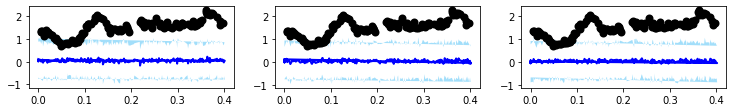

In [16]:
my_utils.viz_per_example(Edelson.dataset[5], net, device=device, k_iwae=20, fracs=[.5,0.8,.9])

0.01
